In [ ]:
from oauth2client.client import GoogleCredentials

#from google.colab import auth as google_auth
#google_auth.authenticate_user()
#from google.colab import drive
#drive.mount('/content/gdrive')
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
path = '/content/drive/MyDrive/IIT Chicago /Coursework /OULAD_analysis/'

assessments = pd.read_csv(path + "assessments.csv")

courses = pd.read_csv(path + "courses.csv")

student_assessment = pd.read_csv(path + "studentAssessment.csv")

student_info = pd.read_csv(path + "studentInfo.csv")

student_registration = pd.read_csv(path + "studentRegistration.csv")

student_vle = pd.read_csv(path + "studentVle.csv")

vle = pd.read_csv(path + "vle.csv")

domains=pd.DataFrame(
    {
        "code_module": ["AAA", "BBB", "CCC", "DDD", "EEE", "FFF", "GGG"],
        "domain": [
            "Social Sciences",
            "Social Sciences",
            "STEM",
            "STEM",
            "STEM",
            "STEM",
            "Social Sciences",
        ],
    },
)

In [ ]:
# Handling weights for module GGG
assessments.loc[(assessments['code_module']=='GGG') & (assessments['weight']==0), 'weight'] = 11.11
# Handling weights for module FFF
assessments.loc[(assessments['code_module']=='FFF') & (assessments['weight']==0), 'weight'] = 14.29

# Dropout Prediction

## Preprocessing

In [ ]:
## create % of on-time submissions feature in next iteration
assessmentsCombinedDf = student_assessment.merge(assessments, on=['id_assessment'])

assessmentsCombinedDf['weighted_score'] = assessmentsCombinedDf['score'] * assessmentsCombinedDf['weight'] / 100
assessmentsCombinedDf['sum_weighted_score'] = assessmentsCombinedDf.groupby(["code_module","code_presentation","id_student"])['weighted_score'].transform('sum')
assessmentsCombinedDf['sum_weight'] = assessmentsCombinedDf.groupby(["code_module","code_presentation","id_student"])['weight'].transform('sum')

assessmentsCombinedDf['OntimeSubmission'] = np.where(assessmentsCombinedDf["date_submitted"] <= assessmentsCombinedDf["date"], 1, 0)
assessmentsCombinedDf['ontime_sum'] = assessmentsCombinedDf.groupby(["code_module","code_presentation","id_student"])['OntimeSubmission'].transform('sum')
assessmentsCombinedDf['ontime_count'] = assessmentsCombinedDf.groupby(["code_module","code_presentation","id_student"])['OntimeSubmission'].transform('count')

assessmentsCombinedDf = assessmentsCombinedDf.groupby(['code_module','code_presentation','id_student'], as_index=False).last()
assessmentsCombinedDf['final_weighted_score'] = assessmentsCombinedDf['sum_weighted_score'] / assessmentsCombinedDf['sum_weight']
assessmentsCombinedDf["perc_ontime_sub"] = assessmentsCombinedDf['ontime_sum'] / assessmentsCombinedDf['ontime_count']

assessmentsCombinedDf.drop(["id_assessment", "score", "date", "weight", "weighted_score", "sum_weighted_score",
                            "sum_weight", "OntimeSubmission", "ontime_sum", "ontime_count", "date_submitted",
                            "assessment_type"], axis=1, inplace=True)

In [ ]:
vleCombinedDf = student_vle.merge(vle, on=['code_module','code_presentation', 'id_site']).drop(['week_from', 'week_to'], axis=1)
vleCombinedDf['avgClicksPerDay'] = (vleCombinedDf.groupby(['code_module','code_presentation','id_student'])['sum_click']
                                    .transform('mean'))
vleCombinedDf = vleCombinedDf.groupby(['code_module','code_presentation','id_student'], as_index=False).first()
vleCombinedDf.drop(["id_site", "date", "activity_type", "sum_click"], axis=1, inplace=True)

In [ ]:
std_reg_courses = student_registration.merge(courses, on=["code_module","code_presentation"])
std_reg_courses_domain = std_reg_courses.merge(domains, on="code_module")
std_reg_courses_domain.drop(['date_registration','date_unregistration'], axis=1, inplace=True)
# std_reg_courses_domain.head()

In [ ]:
std_info_reg_courses_domain = student_info.merge(std_reg_courses_domain, on=["code_module", "code_presentation", "id_student"])
std_info_reg_courses_domain_vle = std_info_reg_courses_domain.merge(vleCombinedDf, on=["code_module", "code_presentation", "id_student"])
finalCombinedDf = std_info_reg_courses_domain_vle.merge(assessmentsCombinedDf, on=["code_module", "code_presentation", "id_student"])
# finalCombinedDf.head()

## Missing values handling

In [ ]:
finalCombinedDf.loc[(finalCombinedDf.final_weighted_score.isna()), 'final_weighted_score'] = 0
finalCombinedDf.loc[(finalCombinedDf.imd_band.isna()), 'imd_band'] = '50-60%'

## Cluster based column creation

### demographic **cluster**


In [ ]:
!pip install kmodes

In [ ]:
from kmodes.kprototypes import KPrototypes

cluster_stdInfo = finalCombinedDf.copy()

# Assume df is already loaded and contains the required columns
categorical_columns = ['gender', 'highest_education', 'imd_band', 'age_band', 'disability', 'region']
numerical_columns = ['num_of_prev_attempts', 'studied_credits']

# Convert categorical columns to category dtypes
for col in categorical_columns:
    cluster_stdInfo[col] = cluster_stdInfo[col].astype('category')

# Creating a copy of the data for clustering that excludes the key columns
cluster_stdInfo = cluster_stdInfo[categorical_columns + numerical_columns].copy()
cluster_stdInfo[categorical_columns] = cluster_stdInfo[categorical_columns].apply(lambda x: x.cat.codes)

# Convert the DataFrame to a NumPy array
data_matrix = cluster_stdInfo.to_numpy()

kproto = KPrototypes(n_clusters=5, init='Cao', n_init=5, verbose=1)

clusters = kproto.fit_predict(data_matrix, categorical=[cluster_stdInfo.columns.get_loc(c) for c in categorical_columns])

finalCombinedDf['demographic_cluster'] = clusters

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 4629, ncost: 5352920.469548262
Run: 1, iteration: 2/100, moves: 569, ncost: 4924301.792552458
Run: 1, iteration: 3/100, moves: 12, ncost: 4923970.048838119
Run: 1, iteration: 4/100, moves: 0, ncost: 4923970.048838119
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 4217, ncost: 5312406.147222668
Run: 2, iteration: 2/100, moves: 566, ncost: 4890551.76548351
Run: 2, iteration: 3/100, moves: 12, ncost: 4890220.042067583
Run: 2, iteration: 4/100, moves: 0, ncost: 4890220.042067583
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 720, ncost: 2587502.0574693126
Run: 3, iteration: 2/100, moves: 19, ncost: 2587154.8085344974
Run: 3, iteration: 3/100, moves: 0, ncost: 2587154.8085344

<Axes: ylabel='count'>

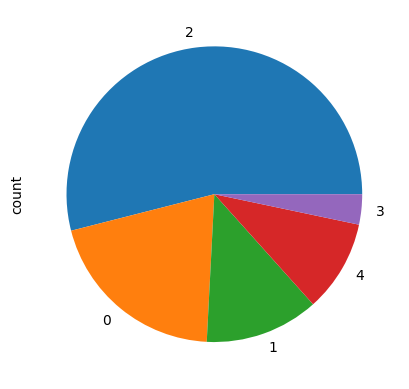

In [ ]:
finalCombinedDf.demographic_cluster.value_counts().plot.pie()

In [ ]:
finalCombinedDf.demographic_cluster.value_counts(dropna=0)

demographic_cluster
2    13922
0     5211
1     3213
4     2594
3      853
Name: count, dtype: int64

### behavioural cluster

In [ ]:
from sklearn.cluster import KMeans

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
finalCombinedDf['behavioural_cluster'] = kmeans.fit_predict(finalCombinedDf[['avgClicksPerDay']])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:

# # Visualize the clusters
# plt.scatter(finalCombinedDf['avgClicksPerDay'], [0] * len(finalCombinedDf), c=finalCombinedDf['behavioural_cluster'], cmap='viridis', marker='|')
# plt.xlabel('avgClicksPerDay')
# plt.yticks([])
# plt.title('Clustering Students based on avg clicks per day')
# plt.show()


### assesments cluster

In [ ]:
finalCombinedDf['assesments_cluster'] = kmeans.fit_predict(finalCombinedDf[['perc_ontime_sub',
                                                                            'final_weighted_score']])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Encoding

In [ ]:
ordinal_features = ['imd_band','highest_education']
nominal_features = ['code_module','code_presentation','gender','region','age_band','disability']

In [ ]:
def OrdMapping(df):

    imd_band_mapping = {'0-10%': 0,'10-20': 1,'20-30%': 2 , '30-40%':3,'40-50%': 4, '50-60%':5, '60-70%':6, '70-80%':7, '80-90%':8, '90-100%':9 }
    highest_education_mapping= {'No Formal quals':0, 'Lower Than A Level':2, 'A Level or Equivalent':3, 'HE Qualification':4,'Post Graduate Qualification':5}

    df['imd_band'] = df.imd_band.map(imd_band_mapping)
    df['highest_education'] = df.highest_education.map(highest_education_mapping)

    return df

In [ ]:
# ordinal encoding
ordMapped_df = OrdMapping(finalCombinedDf)

# One hot encoding
onehotEncoded_df = pd.get_dummies(ordMapped_df, columns=nominal_features, drop_first=True, dtype=float)

## Modeling

In [ ]:
onehotEncoded_df['isDropout'] = np.where(onehotEncoded_df["final_result"] == "Withdrawn", 1, 0)
onehotEncoded_df.isDropout.value_counts()

isDropout
0    21120
1     4673
Name: count, dtype: int64

<Axes: ylabel='count'>

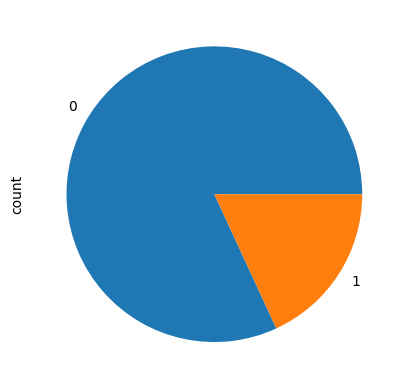

In [ ]:
onehotEncoded_df.isDropout.value_counts().plot.pie()

In [ ]:
onehotEncoded_df.describe()

,id_student,highest_education,imd_band,num_of_prev_attempts,studied_credits,module_presentation_length,avgClicksPerDay,is_banked,final_weighted_score,perc_ontime_sub,...,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region,age_band_35-55,age_band_55<=,disability_Y,isDropout
count,2.579300e+04,25793.000000,25793.000000,25793.000000,25793.000000,25793.000000,25793.000000,25793.000000,25793.000000,25793.000000,...,25793.000000,25793.000000,25793.000000,25793.000000,25793.000000,25793.000000,25793.000000,25793.00000,25793.000000,25793.000000
mean,7.085493e+05,2.768619,4.365138,0.155120,76.778389,256.123406,3.363473,0.009460,0.700663,0.685846,...,0.065405,0.097352,0.075912,0.067189,0.076145,0.060288,0.298220,0.00725,0.093553,0.181173
std,5.543334e+05,0.777991,2.760983,0.465895,38.286432,13.142867,1.171479,0.096803,0.175717,0.329001,...,0.247245,0.296442,0.264863,0.250353,0.265235,0.238024,0.457486,0.08484,0.291211,0.385169
min,6.516000e+03,0.000000,0.000000,0.000000,30.000000,234.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,5.057220e+05,2.000000,2.000000,0.000000,60.000000,241.000000,2.465587,0.000000,0.610000,0.444444,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,5.892950e+05,3.000000,4.000000,0.000000,60.000000,262.000000,3.195402,0.000000,0.732400,0.800000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,6.428830e+05,3.000000,7.000000,0.000000,90.000000,268.000000,4.070225,0.000000,0.827200,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000
max,2.698588e+06,5.000000,9.000000,6.000000,630.000000,269.000000,20.028933,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [ ]:
onehotEncoded_df.columns

Index(['id_student', 'highest_education', 'imd_band', 'num_of_prev_attempts',
       'studied_credits', 'final_result', 'module_presentation_length',
       'domain', 'avgClicksPerDay', 'is_banked', 'final_weighted_score',
       'perc_ontime_sub', 'demographic_cluster', 'behavioural_cluster',
       'assesments_cluster', 'code_module_BBB', 'code_module_CCC',
       'code_module_DDD', 'code_module_EEE', 'code_module_FFF',
       'code_module_GGG', 'code_presentation_2013J', 'code_presentation_2014B',
       'code_presentation_2014J', 'gender_M', 'region_East Midlands Region',
       'region_Ireland', 'region_London Region', 'region_North Region',
       'region_North Western Region', 'region_Scotland',
       'region_South East Region', 'region_South Region',
       'region_South West Region', 'region_Wales',
       'region_West Midlands Region', 'region_Yorkshire Region',
       'age_band_35-55', 'age_band_55<=', 'disability_Y', 'isDropout'],
      dtype='object')

In [ ]:
onehotEncoded_df.shape

(25793, 41)

## Saving the data

In [ ]:
# onehotEncoded_df.to_csv("modeling_data.csv")

## Retrieving data

In [ ]:
# onehotEncoded_df = pd.read_csv(path + "modeling_data.csv", index_col="Unnamed: 0")

In [ ]:
onehotEncoded_df.shape

(25793, 41)

In [ ]:
# final df
features = ['highest_education', 'imd_band', 'num_of_prev_attempts',
       'studied_credits', 'module_presentation_length',
       'avgClicksPerDay', 'is_banked', 'final_weighted_score',
       'perc_ontime_sub', 'demographic_cluster', 'behavioural_cluster',
       'assesments_cluster', 'code_module_BBB', 'code_module_CCC',
       'code_module_DDD', 'code_module_EEE', 'code_module_FFF',
       'code_module_GGG', 'code_presentation_2013J', 'code_presentation_2014B',
       'code_presentation_2014J', 'gender_M', 'region_East Midlands Region',
       'region_Ireland', 'region_London Region', 'region_North Region',
       'region_North Western Region', 'region_Scotland',
       'region_South East Region', 'region_South Region',
       'region_South West Region', 'region_Wales',
       'region_West Midlands Region', 'region_Yorkshire Region',
       'age_band_35-55', 'age_band_55<=', 'disability_Y']

target = ['isDropout']

final_df = onehotEncoded_df[features + target]

In [ ]:
final_df.shape

(25793, 38)

In [ ]:
scoring = {'accuracy' : make_scorer(accuracy_score),
              'precision' : make_scorer(precision_score),
              'recall' : make_scorer(recall_score),
              'f1_score' : make_scorer(f1_score),
               'roc_auc' : 'roc_auc'}

# load dataset
X_ = final_df[features].values
y = final_df.isDropout.values

# prepare models
# DT
# RF
# XGB
# LGBM
models = []
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('XGBoost', XGBClassifier()))
models.append(('LightGBM', LGBMClassifier(force_row_wise=True, verbose=-1, verbose_eval=False)))

In [ ]:
# evaluate each model in turn
results = []
names = []

for name, model in models:
    kfold = model_selection.KFold(n_splits=5)
    cv_results = model_selection.cross_validate(model, X_, y, cv=kfold, scoring=scoring)

    mean_accuracy = np.mean(cv_results["test_accuracy"])
    mean_precision = np.mean(cv_results["test_precision"])
    mean_recall = np.mean(cv_results["test_recall"])
    mean_f1_score = np.mean(cv_results["test_f1_score"])
    mean_roc_auc = np.mean(cv_results["test_roc_auc"])

    results.append([mean_accuracy, mean_precision, mean_recall, mean_f1_score, mean_roc_auc])
    names.append(name)



In [ ]:
final_results_df = pd.DataFrame(data = results, index = names, columns=["mean_accuracy", "mean_precision",
                                                                        "mean_recall", "mean_f1_score",
                                                                        "mean_roc_auc"])
final_results_df

,mean_accuracy,mean_precision,mean_recall,mean_f1_score,mean_roc_auc
DT,0.737875,0.294583,0.335904,0.311498,0.580204
RF,0.825498,0.565891,0.143914,0.214356,0.716539
XGBoost,0.817705,0.475189,0.213075,0.288839,0.745313
LightGBM,0.824296,0.544271,0.165026,0.244415,0.761649


## Sampling with cross validation

In [ ]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE

In [ ]:
sampled_data_results = []
names = []

for name, model in models:

    imba_pipeline = make_pipeline(SMOTE(random_state=42),
                                  model)

    kfold = model_selection.KFold(n_splits=5)
    cv_sampled_results = model_selection.cross_validate(imba_pipeline, X_, y, cv=kfold, scoring=scoring)

    mean_accuracy = np.mean(cv_sampled_results["test_accuracy"])
    mean_precision = np.mean(cv_sampled_results["test_precision"])
    mean_recall = np.mean(cv_sampled_results["test_recall"])
    mean_f1_score = np.mean(cv_sampled_results["test_f1_score"])
    mean_roc_auc = np.mean(cv_sampled_results["test_roc_auc"])

    sampled_data_results.append([mean_accuracy, mean_precision, mean_recall, mean_f1_score, mean_roc_auc])
    names.append(name)


In [ ]:
# for i, (train_index, test_index) in enumerate(kfold.split(X_)):
#     print(f"Fold {i}:")
#     print(f"  Train_index: {train_index}")
#     print(f"  Train: n={len(train_index)}")

#     print(f"  Test_index: {test_index}")
#     print(f"  Test: n={len(test_index)}")

In [ ]:
final_results_df_withSampling = pd.DataFrame(data = sampled_data_results,
                                             index = names, columns=["mean_accuracy", "mean_precision",
                                                                        "mean_recall", "mean_f1_score",
                                                                        "mean_roc_auc"])
final_results_df_withSampling

,mean_accuracy,mean_precision,mean_recall,mean_f1_score,mean_roc_auc
DT,0.700386,0.257225,0.350149,0.292952,0.563106
RF,0.817550,0.497600,0.144845,0.216112,0.679809
XGBoost,0.806849,0.444285,0.223869,0.283812,0.709228
LightGBM,0.822823,0.519883,0.149523,0.226192,0.737737
